#  <font color='red'>Table of Contents</font>


[11. Baseline LSTM (Colab)](#section11)<br>

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [0]:
#ref - https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import math
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
from IPython.display import Image
import os
print('CWD is ',os.getcwd())

# Vis Libs..
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Libs..
import re
from gensim import corpora, models
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

# ML Libs...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import GridSearchCV

# DL Libs..
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input , Dropout, Flatten,concatenate,LSTM
from tensorflow.keras.layers import Embedding
import tensorflow.keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

# Colab Libs...
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

CWD is  /content


#  <a id = 'section11'> <font color='red'>  11. Baseline LSTM (colab)  </font> </a>

### <font color='red'> 11.1 Setup Colab Environment </font>

In [ ]:
'''
Code below sets up Google Colab to load the input files from
Google Drive and can output files as well
'''

In [0]:
# Importing Libraries
#ref - https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Mercari2')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  /content/gdrive/My Drive/Mercari2


### <font color='red'> 11.2 Load Data From GDrive </font>

In [0]:
file = open('df_train_model', 'rb')
df_train_model = pickle.load(file)
file.close()

file = open('df_test_model', 'rb')
df_test_model = pickle.load(file)
file.close()

print(df_train_model.shape,df_test_model.shape)

(1111901, 8) (370634, 8)


In [0]:
# ref - https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755

df_train_model = df_train_model[(df_train_model.price >= 3) & (df_train_model.price <= 2000)]
print(df_train_model.shape)

(1111222, 8)


### <font color='red'> 11.3 Encoding Text Data - 'Item Name, Item Description' </font>

In [0]:
'''
Code for Text Cleaning & Preprocessing 
'''

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

def text_preprocess(data):
    preprocessed = []
    # tqdm is for printing the status bar
    for sentance in tqdm_notebook(data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [0]:
''' This Code uses Keras tokeizer to create Word Tokens from the Text Vocabulary, 
it takes in train,test text data as input, 
returns keras tokenizer and tokeized train,test datasets '''

def text_tokenize(train,test):
    t = Tokenizer()
    t.fit_on_texts(train)
    #print('Total number of words in the document are ',len(t.word_index) + 1)
    train_tokenized = t.texts_to_sequences(train)
    test_tokenized = t.texts_to_sequences(test)
    return train_tokenized,test_tokenized,t

In [0]:
''' This Code takes train,test data and performs Pre-padding with (max_length= sl)
which can be input as required'''

def text_padding(train,test,sl):
    padded_train_text = pad_sequences(train, maxlen = sl, padding='pre')
    padded_test_text = pad_sequences(test, maxlen = sl, padding='pre')
    return padded_train_text,padded_test_text

##### Performing Text Processing Pipeline - Clean > Preprocess > Encoder > Padding

In [0]:
df_train_model['name'] = df_train_model['name'].replace([np.nan], '')
df_test_model['name'] = df_test_model['name'].replace([np.nan], '')

df_train_model['item_description'] = df_train_model['item_description'].replace([np.nan,'No description yet'], '')
df_test_model['item_description'] = df_test_model['item_description'].replace([np.nan,'No description yet'], '')

In [0]:
train_name = text_preprocess(df_train_model['name'])
test_name = text_preprocess(df_test_model['name'])

train_desc = text_preprocess(df_train_model['item_description'])
test_desc = text_preprocess(df_test_model['item_description'])

In [0]:
train_name,test_name,tokenizer_name = text_tokenize(train_name,test_name)
train_desc,test_desc,tokenizer_desc = text_tokenize(train_desc,test_desc)

In [0]:
'''
This code selects the optimum padding length based on
most commonly occuring sentence length by analyzing sentence lengths 
distribution across sentences
'''

def select_padding(train,t,col,sen_len):
    len_texts = [len(x) for x in train]
    print('Total number of words in the document are ',len(t.word_index) + 1)
    print((len(list(filter(lambda x : x > sen_len,len_texts)))/len(len_texts))*100, 
          " % of rows have sentence length > ",sen_len,'\n')
    sns.distplot(len_texts, kde=False).set_title("Padding Length Selection of "+ str(col))
    plt.show()

Total number of words in the document are  89577
0.009989003097490871  % of rows have sentence length >  10 



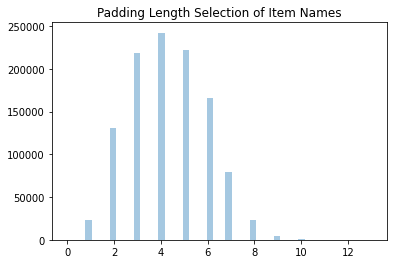

In [0]:
select_padding(train_name,tokenizer_name,"Item Names",10)

Total number of words in the document are  138419
0.5927708414700212  % of rows have sentence length >  125 



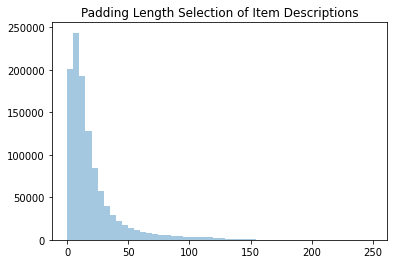

In [0]:
select_padding(train_desc,tokenizer_desc,"Item Descriptions",125)

In [0]:
# Selecting these values from the graph above
NAME_LENGTH = 10
DESC_LENGTH = 125

In [0]:
train_name_pad,test_name_pad = text_padding(train_name,test_name,NAME_LENGTH)
train_desc_pad,test_desc_pad = text_padding(train_desc,test_desc,DESC_LENGTH)

### <font color='red'> 11.4 Encoding Categorical Features - 'Cat,Brand,Ship,Item-Cond' </font>

In [0]:
'''
This Code performs Categorical Feature to Numeric 
Encodings based on Ranks by Word Frequency in the Vocabulary,
takes train,test as input and returns encoded train,test data
and the vocab size as output
'''

def self_token(column):
    unique = list(set(column))
    total = list(column)
    size = len(unique)
    count = []
    for category in unique:
        count.append([total.count(category),category])
    count.sort()
    rank = {}
    for i in range(1,len(count)+1):
        rank.update({count[i-1][1] : i})
    return (rank , unique,size)

def category_encoder(train,test):
    cat_rank, unique,size = self_token(train)
    encoded_train = []
    encoded_test = []
    for category in train:
        encoded_train.append(cat_rank[category])

    for category in test:
        if category in unique:
            encoded_test.append(cat_rank[category]) 
        else:
            encoded_test.append(0) 
    encoded_train = np.asarray(encoded_train)
    encoded_test = np.asarray(encoded_test)
    return encoded_train,encoded_test,size

In [0]:
train_ship,test_ship,ship_size = category_encoder(df_train_model['shipping'].astype('category'),
                                                  df_test_model['shipping'].astype('category'))
train_ici,test_ici,ici_size = category_encoder(df_train_model['item_condition_id'].astype('category'),
                                                  df_test_model['item_condition_id'].astype('category'))
train_brand,test_brand,brand_size = category_encoder(df_train_model['brand_name'].fillna('missing').astype('category'),
                                                  df_test_model['brand_name'].fillna('missing').astype('category'))
train_cat,test_cat,cat_size = category_encoder(df_train_model['category_name'].fillna('missing').astype('category'),
                                                  df_test_model['category_name'].fillna('missing').astype('category'))

### <font color='red'> 11.5 Create Embedding Layers </font>

In [0]:
'''
This Code creates an embedding matrix using Glove 300-D
vector representation of words. 
It Creates an Embedding Matrix of 
shape (vocab_size,300)
'''

def generate_embedding_matrix(token):
    with open('glove_vectors', 'rb') as f:
        model = pickle.load(f)
        glove_words =  set(model.keys())
        
    embedding_matrix_text = np.zeros((len(token.word_index) + 1, 300))
    for word, i in tqdm_notebook(token.word_index.items()):
        if word in glove_words:
            embedding_vector = model[word]
            embedding_matrix_text[i] = embedding_vector
    
    return embedding_matrix_text

In [0]:
embedding_name = generate_embedding_matrix(tokenizer_name)
embedding_desc = generate_embedding_matrix(tokenizer_desc)
print(embedding_name.shape,embedding_desc.shape)


(89577, 300) (138419, 300)


### <font color='red'> 11.6 Numeric Features - 17 new Features generated </font>

In [0]:
'''
Loading the 17 features generated in the Feature engineering section
'''

file = open('train_desc_feats', 'rb')
train_desc_feats = pickle.load(file)
file.close()
file = open('test_desc_feats', 'rb')
test_desc_feats = pickle.load(file)
file.close()
#####################################################################
file = open('train_senti_names', 'rb')
train_senti_names = pickle.load(file)
file.close()
file = open('test_senti_names', 'rb')
test_senti_names = pickle.load(file)
file.close()

file = open('train_senti_desc', 'rb')
train_senti_desc = pickle.load(file)
file.close()
file = open('test_senti_desc', 'rb')
test_senti_desc = pickle.load(file)
file.close()
#####################################################################
file = open('train_cbs_feats', 'rb')
train_cbs_feats = pickle.load(file)
file.close()
file = open('test_cbs_feats', 'rb')
test_cbs_feats = pickle.load(file)
file.close()

In [0]:
'''Creating Feature stack using np.hstack to pass into LSTM model'''

X_train_numerics = np.hstack((train_desc_feats,
                              np.array(train_senti_names).reshape(-1,1),
                              np.array(train_senti_desc).reshape(-1,1),
                              train_cbs_feats))
X_test_numerics = np.hstack((test_desc_feats,
                              np.array(test_senti_names).reshape(-1,1),
                              np.array(test_senti_desc).reshape(-1,1),
                              test_cbs_feats))

print(X_train_numerics.shape,X_test_numerics.shape)

(1111222, 17) (370634, 17)


In [0]:
'''Creating the Train,Test Input to pass into LSTM Input Layers as list'''

X_train = [train_name_pad,train_desc_pad,
         np.array(train_ship),np.array(train_ici),np.array(train_brand),np.array(train_cat),
         X_train_numerics]
X_test =  [test_name_pad,test_desc_pad,
         np.array(test_ship),np.array(test_ici),np.array(test_brand),np.array(test_cat),
         X_test_numerics]
y_train = np.log1p(df_train_model['price'])
y_test = np.log1p(df_test_model['price'])

In [0]:
'''
file = open('X_train', 'wb')
pickle.dump(X_train, file)
file.close()
file = open('X_test', 'wb')
pickle.dump(X_test, file)
file.close()

file = open('y_train', 'wb')
pickle.dump(y_train, file)
file.close()
file = open('y_test', 'wb')
pickle.dump(y_test, file)
file.close()

file = open('tokenizer_name', 'wb')
pickle.dump(tokenizer_name, file)
file.close()
file = open('tokenizer_desc', 'wb')
pickle.dump(y_test, file)
file.close()

file = open('embedding_name', 'wb')
pickle.dump(embedding_name, file)
file.close()
file = open('embedding_desc', 'wb')
pickle.dump(embedding_desc, file)
file.close()
'''

### <font color='red'> 11.7 Create LSTM Model </font>

In [0]:
'''
This Code builds the LSTM Model Architecture based on Input Data size, parameters passed
'''

def build_lstm_model(NAME_LENGTH,tokenizer_name,embedding_name,DESC_LENGTH,tokenizer_desc,embedding_desc,ship_size,ici_size,brand_size,cat_size,NUMERIC_LENGTH):
    
    text_input_name = Input(shape=(NAME_LENGTH,), name='TEXT_ITEM_NAME')
    x = Embedding(len(tokenizer_name.word_index) + 1, 300, weights=[embedding_name], input_length=NAME_LENGTH)(text_input_name)
    lstm_out = LSTM(100,recurrent_dropout=0.25,return_sequences=True)(x)
    flatten_1 = Flatten()(lstm_out)
    
    text_input_desc = Input(shape=(DESC_LENGTH,), name='TEXT_DESC_NAME')
    x = Embedding(len(tokenizer_desc.word_index) + 1, 300, weights=[embedding_desc], input_length=DESC_LENGTH)(text_input_desc)
    lstm_out = LSTM(100,recurrent_dropout=0.25,return_sequences=True)(x)
    flatten_2 = Flatten()(lstm_out)

    shipping_feat = Input(shape=(1,), name='SHIPPING')
    x = Embedding(ship_size + 1, 10, input_length=1)(shipping_feat)
    flatten_3 = Flatten()(x)

    item_cond_feat = Input(shape=(1,), name='ITEM_CONDITION')
    x = Embedding(ici_size + 1, 10, input_length=1)(item_cond_feat)
    flatten_4 = Flatten()(x)
    
    brand_feat = Input(shape=(1,), name='BRAND')
    x = Embedding(brand_size + 1, 10, input_length=1)(brand_feat)
    flatten_5 = Flatten()(x)
    
    cat_feat = Input(shape=(1,), name='CATEGORY')
    x = Embedding(cat_size + 1, 10, input_length=1)(cat_feat)
    flatten_6 = Flatten()(x)

    numeric_feat = Input(shape=(NUMERIC_LENGTH,), name='NUMERIC_FEATURES')
    dense_1 = Dense(1, activation='relu',kernel_initializer="he_normal",kernel_regularizer=tensorflow.keras.regularizers.l2(0.001))(numeric_feat)

    x = concatenate([flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,flatten_6,dense_1])

    x = Dense(100, activation='relu',kernel_initializer="he_normal",kernel_regularizer=tensorflow.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(50, activation='relu',kernel_initializer="he_normal",kernel_regularizer=tensorflow.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(10, activation='relu',kernel_initializer="he_normal",kernel_regularizer=tensorflow.keras.regularizers.l2(0.001))(x)
    final_output = Dense(1, activation='linear')(x)

    model = Model(inputs=[text_input_name,text_input_desc,
                          shipping_feat,item_cond_feat,brand_feat,cat_feat,
                          numeric_feat], 
                  outputs=[final_output])
    return model

In [0]:
'''Summarizing the Model Built'''

baseline_lstm_model = build_lstm_model(NAME_LENGTH,tokenizer_name,embedding_name,
                                       DESC_LENGTH,tokenizer_desc,embedding_desc,
                                       ship_size,ici_size,brand_size,cat_size,X_train_numerics.shape[1])
baseline_lstm_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TEXT_ITEM_NAME (InputLayer)     [(None, 10)]         0                                            
__________________________________________________________________________________________________
TEXT_DESC_NAME (InputLayer)     [(None, 125)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 300)      26873100    TEXT_ITEM_NAME[0][0]             
_____________________________________________________________________________________________

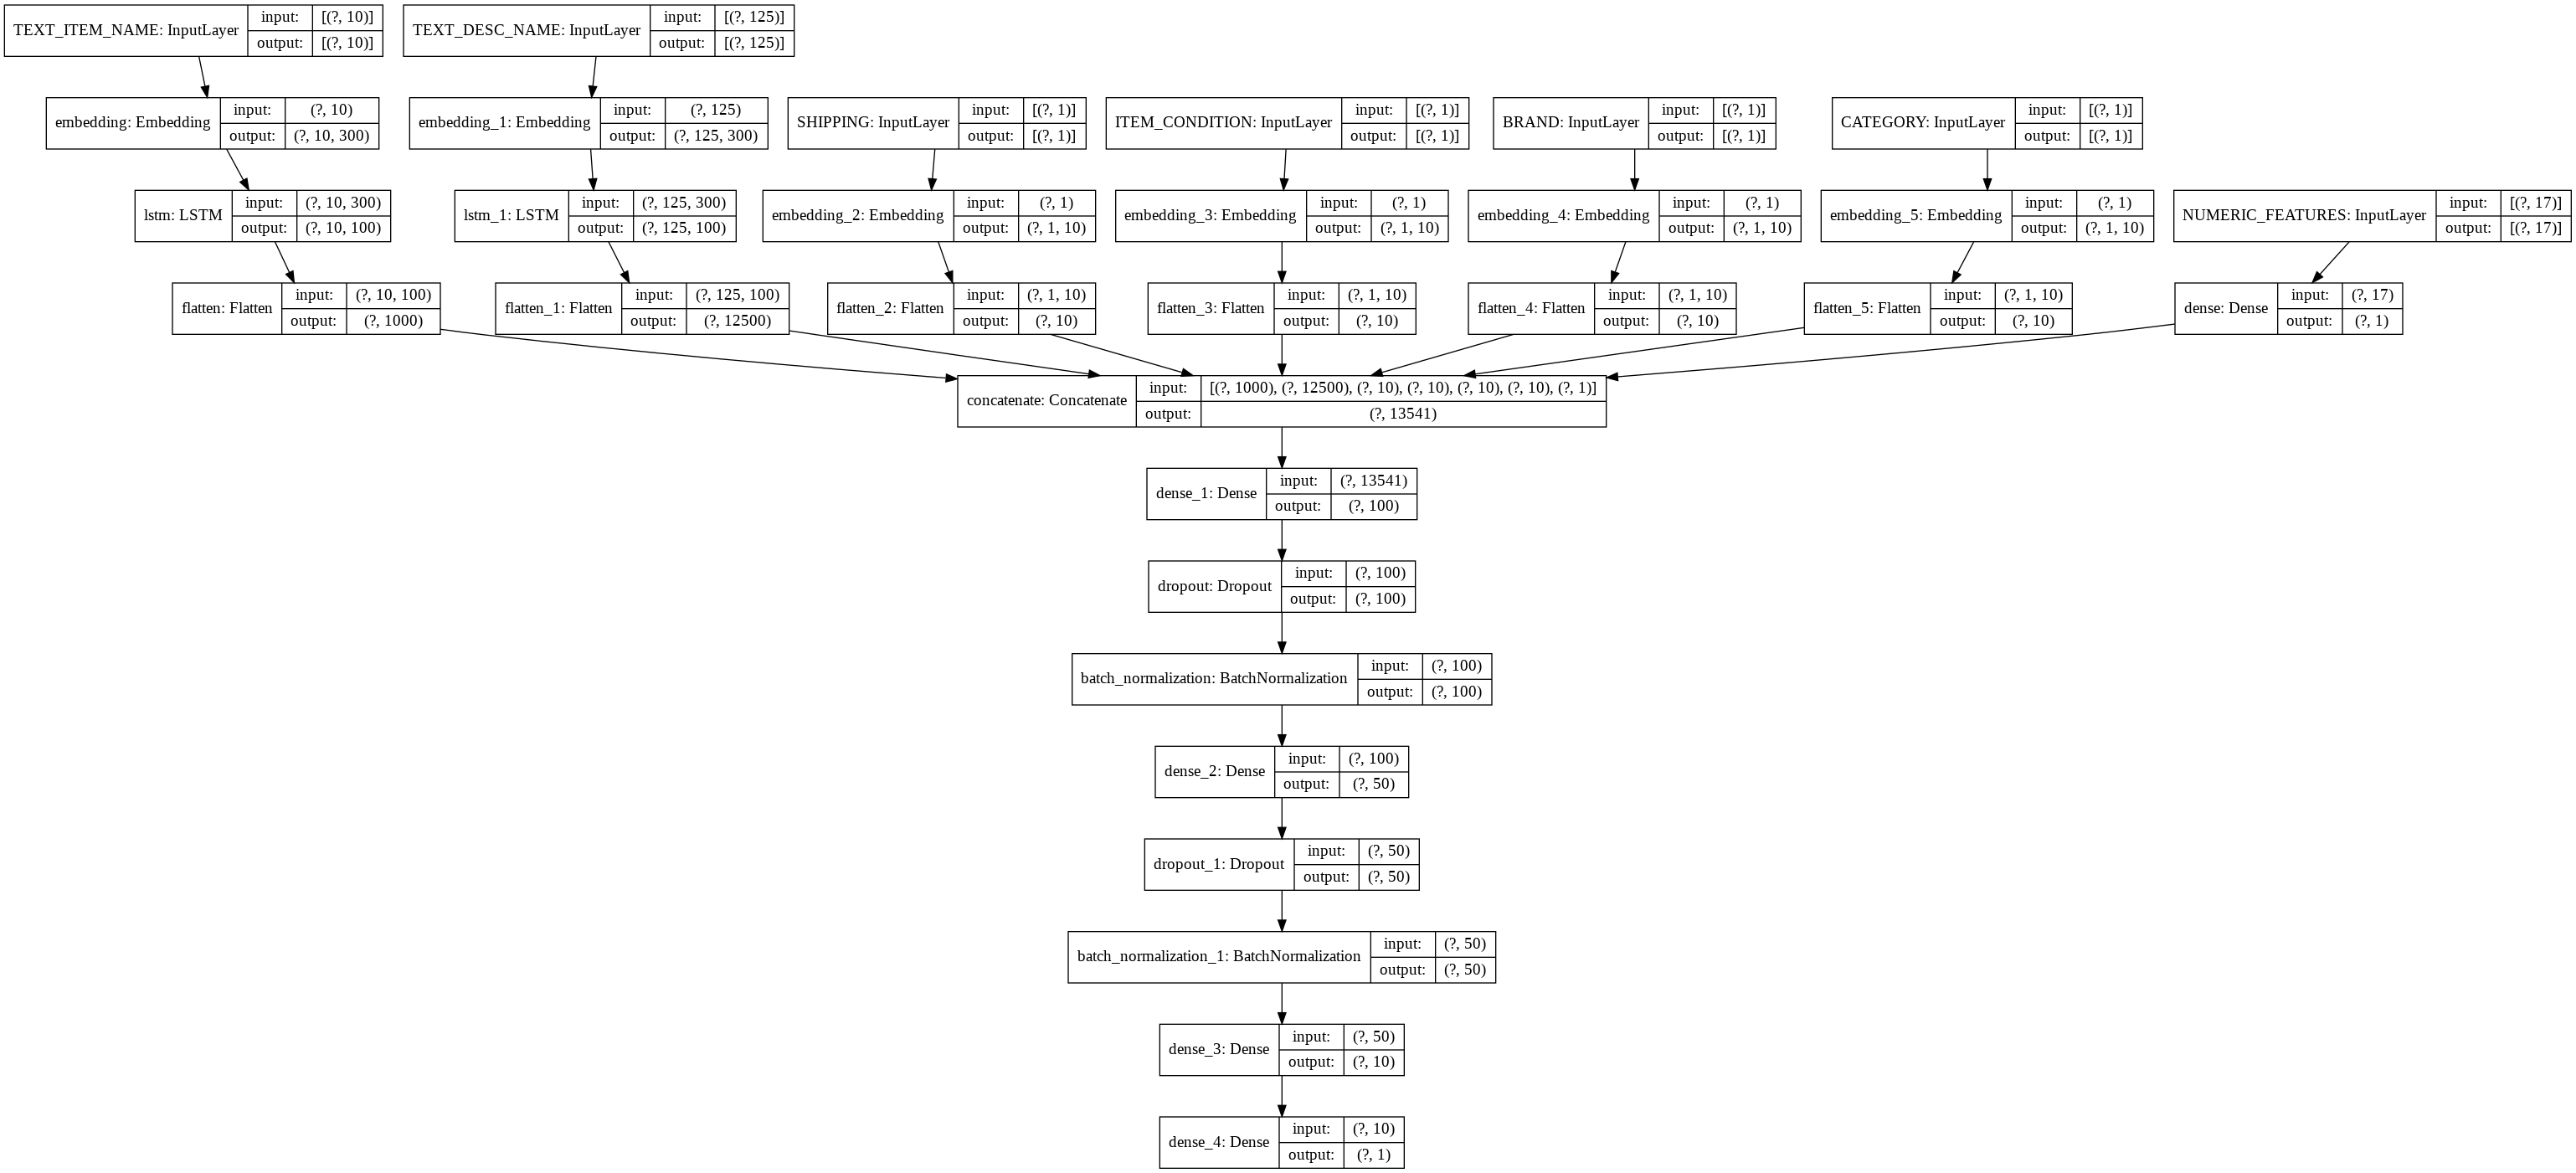

In [0]:
'''Graphical Visualization of LSTM Model'''

plot_model(baseline_lstm_model, to_file='baseline_lstm_model.png', show_shapes=True, show_layer_names=True)
Image(filename='baseline_lstm_model.png')

### <font color='red'> 11.8 Train Model </font>

In [0]:
'''
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
'''
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
'''Training LSTM Model for 100 epochs using Adam Optimizer with Batch Size = 4096'''

baseline_lstm_model.compile(optimizer='adam', loss='mean_squared_error')
filepath = "baseline_lstm_model_epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5"

checkpoint = ModelCheckpoint(filepath,monitor="val_loss",mode="min",save_best_only = True,verbose = 1)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='/content/gdrive/My Drive/Mercari2/log_baseline_lstm_model')
callbacks_list = [checkpoint,tensorboard]

history_baseline_lstm_model = baseline_lstm_model.fit(X_train,y_train, 
                                                      batch_size=4096, 
                                                      epochs=100, 
                                                      verbose=1, 
                                                      validation_data=(X_test, y_test),
                                                      callbacks = callbacks_list)

Train on 1111222 samples, validate on 370634 samples
Epoch 1/100
1110016/1111222 [============================>.] - ETA: 0s - loss: 1.6741
Epoch 00001: val_loss improved from inf to 0.72822, saving model to baseline_lstm_model_epochs:001-val_loss:0.728.hdf5
1111222/1111222 [==============================] - 171s 154us/sample - loss: 1.6729 - val_loss: 0.7282
Epoch 2/100
1110016/1111222 [============================>.] - ETA: 0s - loss: 0.4438
Epoch 00002: val_loss improved from 0.72822 to 0.44445, saving model to baseline_lstm_model_epochs:002-val_loss:0.444.hdf5
1111222/1111222 [==============================] - 170s 153us/sample - loss: 0.4437 - val_loss: 0.4445
Epoch 3/100
1110016/1111222 [============================>.] - ETA: 0s - loss: 0.3302
Epoch 00003: val_loss improved from 0.44445 to 0.33200, saving model to baseline_lstm_model_epochs:003-val_loss:0.332.hdf5
1111222/1111222 [==============================] - 172s 154us/sample - loss: 0.3301 - val_loss: 0.3320
Epoch 4/100
111

In [0]:
#%tensorboard --logdir log_baseline_lstm_model

##### Summary - Stopping the model after 68 epochs since no improvement in Validation Loss observed since last 30 epochs

### <font color='red'> 11.9 Test Model </font>

In [0]:
def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

def rmsle_K(y, y0):
    return K.sqrt(K.mean(K.square(tf.log1p(y) - tf.log1p(y0))))

In [0]:
best_model = load_model('/content/gdrive/My Drive/Mercari2/baseline_lstm_model_epochs:012-val_loss:0.261.hdf5',custom_objects={"rmsle_K":rmsle_K})

preds = np.expm1(best_model.predict(X_test,batch_size = 4096,verbose = 1))
print('RMSLE of Test set is ',rmsle_score(np.expm1(y_test).values , preds))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
370634/370634 [==============================] - 17s 47us/sample
RMSLE of Test set is  0.48773672489000885


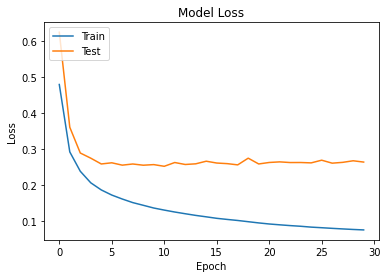

In [0]:
plt.plot(history_baseline_lstm_model.history['loss'])
plt.plot(history_baseline_lstm_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##### Summary - We obtain a Test RMSLE of 0.48, Model does not learn much after 12 epochs, best model at 12th epoch can be used to predict, all models trained after 12th epoch are overfitting.